In [1]:
pip install tf-models-official

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install umap-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [4]:
#@title Download and unzip the data. {display-mode:'form'}
#@markdown The data resides in the GitHub repository. For Hosted Runtime users, it is temporarily downloaded to the runtime's location.

from urllib.request import urlopen
from zipfile import ZipFile
zipurl = 'https://github.com/mtwenzel/parkinson-classification/raw/master/data/PPMI-classification.zip'
zipresp = urlopen(zipurl)
tempzip = open("PPMI-classification.zip", "wb")
tempzip.write(zipresp.read())
tempzip.close()
print("download complete, extracting...")

zf = ZipFile("PPMI-classification.zip")
zf.extractall(path = 'data/')
zf.close()
print("... done")

download complete, extracting...
... done


In [5]:
#@title Imports. {display-mode:'form'}
import pandas as pd
#from sklearn.metrics import confusion_matrix
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,GlobalAveragePooling2D,Flatten,concatenate,BatchNormalization, Dropout
from tensorflow.keras.applications import InceptionV3,DenseNet121
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import official.nlp.modeling.layers as nlp_layers
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
# Visualize the Train/Val loss
import matplotlib.pyplot as plt
%matplotlib inline

2023-08-24 23:14:58.767306: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-24 23:14:58.777923: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-24 23:14:58.939513: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-24 23:14:58.940841: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-24 23:15:00.527051: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [6]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, 109, 91)
else:
    input_shape = (109, 91, 3)

In [7]:
#@title Set the data generators. {display-mode:'form', run: "auto"}
#@markdown Data augmentation choices. Cell runs automatically if anything is changed.
shear_range = 0.1 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
zoom_range = 0.1 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
width_shift_range = 0.1 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
height_shift_range = 0.1 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
rotation_range = 10 #@param {type:"slider", min:0, max:90, step:5}
horizontal_flip = True #@param {type:"boolean"}
vertical_flip = True #@param {type:"boolean"}
#@markdown Data source (No need to change if the download succeeded.)
train_directory = 'training_set/' #@param ['z:/Data/Parkinson_DATScans UKE/full_ppmi_data/png/', '/content/drive/My Drive/MEVIS/Data/PPMI-classification/'] {allow-input: true}
val_directory = 'val_set/'
test_directory = '/home/notebooks/sundar/data_UNSMOOTH/PPMI-classification' 
base_path = '/home/notebooks/sundar'

train_datagen = ImageDataGenerator(rescale=1./255,
                                   
    shear_range=shear_range,
    zoom_range=zoom_range,
    width_shift_range=width_shift_range,
    height_shift_range=height_shift_range,
    rotation_range=rotation_range,
    horizontal_flip=horizontal_flip,
    vertical_flip=vertical_flip)

train_generator = train_datagen.flow_from_directory(os.path.join(base_path,'training_set'), # this is where you specify the path to the main data folder
                                                 target_size=(109,91),
                                                 color_mode='rgb',
                                                 batch_size=64,
                                                 class_mode='sparse',
                                                    seed = 42,
                                                 shuffle=True
                                                    )

val_generator = train_datagen.flow_from_directory(os.path.join(base_path,'val_set'), # this is where you specify the path to the main data folder
                                                 target_size=(109,91),
                                                 color_mode='rgb',
                                                 batch_size=64,
                                                 class_mode='sparse',
                                                  seed = 42,
                                                 shuffle=True
                                                    )

# Data Generator for validation without data augmentation!
test_datagen   = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(os.path.join(test_directory, 'all_2d_val'), # this is where you specify the path to the main data folder
                                                 target_size=(109,91),
                                                 color_mode='rgb',
                                                 batch_size=64,
                                                 class_mode='sparse',
                                                  seed = 42,
                                                 shuffle=True)

Found 904 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 186 images belonging to 2 classes.


In [8]:
batch_size = 32
input_dim = 1024
num_classes = 2
kernel_size = 3

In [9]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = tf.keras.metrics.SparseCategoricalAccuracy(),
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)

train_config = dict(loss=loss, metrics=metrics, optimizer=optimizer)

2023-08-24 23:15:02.960523: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [10]:
fit_config = dict(batch_size=128, epochs=100)

In [11]:
#@title Set the Model {display-mode:'form', run: "auto"}
#@markdown Model architecture choices. Cell runs automatically if anything is changed.
#spectral_norm = True#@param {type:"boolean"}
# utilising functional API to build cnn layers
inputs = Input(shape=input_shape)
y = Conv2D(filters=64,kernel_size=kernel_size,activation='relu')(inputs)
y = Conv2D(filters=64,kernel_size=kernel_size,activation='relu')(y)
y = MaxPooling2D()(y)
y = Conv2D(filters=96, kernel_size=kernel_size, activation='relu')(y)
y = Conv2D(filters=96, kernel_size=kernel_size, activation='relu')(y)
y = MaxPooling2D()(y)
y = Conv2D(filters=128, kernel_size=kernel_size, activation='relu')(y)
y = Conv2D(filters=128, kernel_size=kernel_size, activation='relu')(y)
y = MaxPooling2D()(y)

# convert image to vector 
y = Flatten()(y)
#spectral normalisation

fc0 = tf.keras.layers.Dense(1024)
fcspect = nlp_layers.SpectralNormalization(fc0, norm_multiplier=0.9)(y)
y = Dropout(0.25)(fcspect)
y = tf.keras.layers.Dense(256, activation='relu')(y)
y = tf.keras.layers.Dropout(0.25)(y)
# else:
#   # dropout regularization
#   y = Dropout(0.25)(y)
#   y = tf.keras.layers.Dense(128, activation='relu')(y)
#   y = tf.keras.layers.Dropout(0.25)(y)
#fcspect = nlp_layers.SpectralNormalization(fc0, norm_multiplier=0.9)(fcspect)
#fcspect = nlp_layers.SpectralNormalization(fc0, norm_multiplier=0.9)(fcspect)
#output_layer1 = Dense(2 , activation='softmax')(fcspect)
# gp_layer = nlp_layers.RandomFeatureGaussianProcess(units=num_classes,
#                                                num_inducing=128,
#                                                normalize_input=False,
#                                                scale_random_features=True,
#                                                gp_cov_momentum=-1)
outputs = tf.keras.layers.Dense(2, activation="softmax")(y)
#outputs = (tf.keras.layers.Dense(units=1, activation='sigmoid'))(outputs)
#outputs = Dense(num_labels, activation='softmax')(y)
# model building by supplying inputs/outputs
model1 = Model(inputs=inputs, outputs=outputs)

In [12]:
model1.compile(**train_config)

In [13]:
model1.build((None, 2))

In [14]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 109, 91, 3)]      0         
                                                                 
 conv2d (Conv2D)             (None, 107, 89, 64)       1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 105, 87, 64)       36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 52, 43, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 41, 96)        55392     
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 39, 96)        83040     
                                                             

In [15]:
history1 = model1.fit(train_generator, **fit_config, verbose=1, validation_data=(val_generator))

Epoch 1/100
15/15 [==============================] - 23s 1s/step - loss: 0.6654 - sparse_categorical_accuracy: 0.6748 - val_loss: 0.6377 - val_sparse_categorical_accuracy: 0.6800
Epoch 2/100
15/15 [==============================] - 9s 596ms/step - loss: 0.6391 - sparse_categorical_accuracy: 0.6792 - val_loss: 0.6326 - val_sparse_categorical_accuracy: 0.6800
Epoch 3/100
15/15 [==============================] - 9s 602ms/step - loss: 0.6389 - sparse_categorical_accuracy: 0.6792 - val_loss: 0.6227 - val_sparse_categorical_accuracy: 0.6800
Epoch 4/100
15/15 [==============================] - 9s 600ms/step - loss: 0.6301 - sparse_categorical_accuracy: 0.6792 - val_loss: 0.6041 - val_sparse_categorical_accuracy: 0.6800
Epoch 5/100
15/15 [==============================] - 9s 603ms/step - loss: 0.6049 - sparse_categorical_accuracy: 0.6881 - val_loss: 0.5608 - val_sparse_categorical_accuracy: 0.7250
Epoch 6/100
15/15 [==============================] - 9s 596ms/step - loss: 0.5883 - sparse_catego

In [16]:
model1.save('/MC_Drop_DE1/')

INFO:tensorflow:Assets written to: /MC_Drop_DE1/assets


INFO:tensorflow:Assets written to: /MC_Drop_DE1/assets


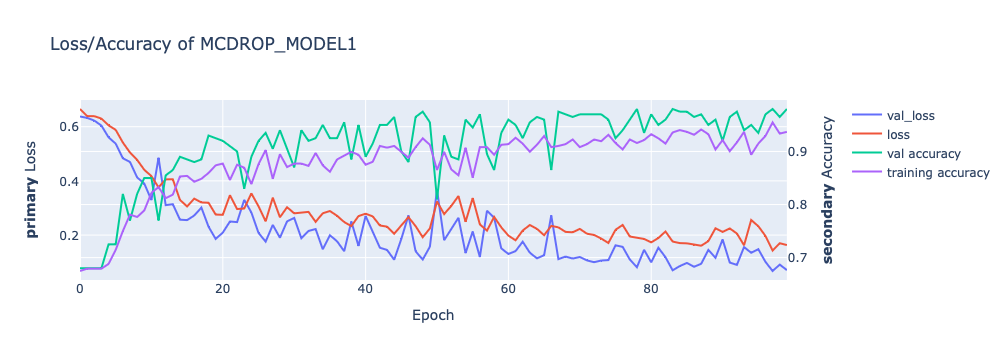

In [17]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter( y=history1.history['val_loss'], name="val_loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=history1.history['loss'], name="loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=history1.history['val_sparse_categorical_accuracy'], name="val accuracy"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter( y=history1.history['sparse_categorical_accuracy'], name="training accuracy"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Loss/Accuracy of MCDROP_MODEL1"
)

# Set x-axis title
fig.update_xaxes(title_text="Epoch")

# Set y-axes titles
fig.update_yaxes(title_text="<b>primary</b> Loss", secondary_y=False)
fig.update_yaxes(title_text="<b>secondary</b> Accuracy", secondary_y=True)

fig.show()

In [18]:
# utilising functional API to build cnn layers
inputs = Input(shape=input_shape)
y = Conv2D(filters=64,kernel_size=kernel_size,activation='relu')(inputs)
y = Conv2D(filters=64,kernel_size=kernel_size,activation='relu')(y)
y = MaxPooling2D()(y)
y = Conv2D(filters=96, kernel_size=kernel_size, activation='relu')(y)
y = Conv2D(filters=96, kernel_size=kernel_size, activation='relu')(y)
y = MaxPooling2D()(y)
y = Conv2D(filters=128, kernel_size=kernel_size, activation='relu')(y)
y = Conv2D(filters=128, kernel_size=kernel_size, activation='relu')(y)
y = MaxPooling2D()(y)

# convert image to vector
y = Flatten()(y)
# dropout regularization
#y = Dropout(dropout)(y)
fc0 = tf.keras.layers.Dense(128)
fcspect = nlp_layers.SpectralNormalization(fc0, norm_multiplier=0.9)(y)
#fcspect = nlp_layers.SpectralNormalization(fc0, norm_multiplier=0.9)(fcspect)
#fcspect = nlp_layers.SpectralNormalization(fc0, norm_multiplier=0.9)(fcspect)
outputs = Dense(2 , activation='softmax')(fcspect)

#outputs = (tf.keras.layers.Dense(units=1, activation='sigmoid'))(outputs)
#outputs = Dense(num_labels, activation='softmax')(y)
# model building by supplying inputs/outputs
model2 = Model(inputs=inputs, outputs=outputs)

In [19]:
model2.compile(**train_config)

In [20]:
model2.build((None, 2))

In [21]:
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 109, 91, 3)]      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 107, 89, 64)       1792      
                                                                 
 conv2d_7 (Conv2D)           (None, 105, 87, 64)       36928     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 52, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 50, 41, 96)        55392     
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 39, 96)        83040     
                                                           

In [22]:
history2 = model2.fit(train_generator, **fit_config, verbose=1, validation_data=(val_generator))

Epoch 1/100
15/15 [==============================] - 10s 620ms/step - loss: 0.6445 - sparse_categorical_accuracy: 0.7246 - val_loss: 0.6243 - val_sparse_categorical_accuracy: 0.6800
Epoch 2/100
15/15 [==============================] - 9s 588ms/step - loss: 0.6328 - sparse_categorical_accuracy: 0.6770 - val_loss: 0.6136 - val_sparse_categorical_accuracy: 0.6800
Epoch 3/100
15/15 [==============================] - 9s 605ms/step - loss: 0.6262 - sparse_categorical_accuracy: 0.6803 - val_loss: 0.6059 - val_sparse_categorical_accuracy: 0.6800
Epoch 4/100
15/15 [==============================] - 9s 568ms/step - loss: 0.6150 - sparse_categorical_accuracy: 0.7046 - val_loss: 0.6184 - val_sparse_categorical_accuracy: 0.6650
Epoch 5/100
15/15 [==============================] - 9s 581ms/step - loss: 0.6087 - sparse_categorical_accuracy: 0.6903 - val_loss: 0.5748 - val_sparse_categorical_accuracy: 0.7000
Epoch 6/100
15/15 [==============================] - 9s 588ms/step - loss: 0.5860 - sparse_cat

In [23]:
model2.save('/BASE_CNN_DE2/')

INFO:tensorflow:Assets written to: /BASE_CNN_DE2/assets


INFO:tensorflow:Assets written to: /BASE_CNN_DE2/assets


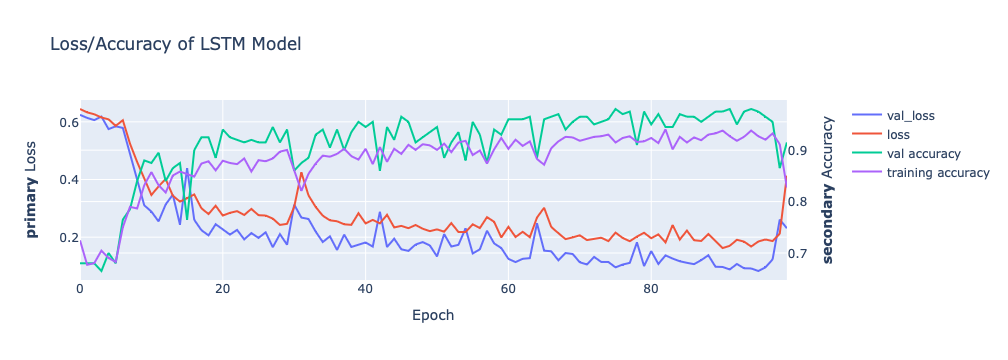

In [24]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter( y=history2.history['val_loss'], name="val_loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=history2.history['loss'], name="loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=history2.history['val_sparse_categorical_accuracy'], name="val accuracy"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter( y=history2.history['sparse_categorical_accuracy'], name="training accuracy"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Loss/Accuracy of LSTM Model"
)

# Set x-axis title
fig.update_xaxes(title_text="Epoch")

# Set y-axes titles
fig.update_yaxes(title_text="<b>primary</b> Loss", secondary_y=False)
fig.update_yaxes(title_text="<b>secondary</b> Accuracy", secondary_y=True)

fig.show()

In [25]:
inputs = Input(shape=input_shape)
y = Conv2D(filters=64,kernel_size=kernel_size,activation='relu')(inputs)
y = Conv2D(filters=64,kernel_size=kernel_size,activation='relu')(y)
y = BatchNormalization()(y)
y = MaxPooling2D()(y)
y = Conv2D(filters=96, kernel_size=kernel_size, activation='relu')(y)
y = Conv2D(filters=96, kernel_size=kernel_size, activation='relu')(y)
y = BatchNormalization()(y)
y = MaxPooling2D()(y)
y = Conv2D(filters=128, kernel_size=kernel_size, activation='relu')(y)
y = Conv2D(filters=128, kernel_size=kernel_size, activation='relu')(y)
y = BatchNormalization()(y)
y = MaxPooling2D()(y)

# convert image to vector
y = Flatten()(y)
# dropout regularization
y = Dropout(0.25)(y)
y = tf.keras.layers.Dense(256, activation='relu')(y)
y = tf.keras.layers.Dropout(0.25)(y)
#fc0 = tf.keras.layers.Dense(128)
#fcspect = nlp_layers.SpectralNormalization(fc0, norm_multiplier=0.9)(y)
#fcspect = nlp_layers.SpectralNormalization(fc0, norm_multiplier=0.9)(fcspect)
#fcspect = nlp_layers.SpectralNormalization(fc0, norm_multiplier=0.9)(fcspect)
outputs = Dense(2 , activation='softmax')(y)

#outputs = (tf.keras.layers.Dense(units=1, activation='sigmoid'))(outputs)
#outputs = Dense(num_labels, activation='softmax')(y)
# model building by supplying inputs/outputs
model3 = Model(inputs=inputs, outputs=outputs)

In [26]:
model3.compile(**train_config)

In [27]:
model3.build((None, 2))

In [28]:
model3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 109, 91, 3)]      0         
                                                                 
 conv2d_12 (Conv2D)          (None, 107, 89, 64)       1792      
                                                                 
 conv2d_13 (Conv2D)          (None, 105, 87, 64)       36928     
                                                                 
 batch_normalization (Batch  (None, 105, 87, 64)       256       
 Normalization)                                                  
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 52, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 50, 41, 96)        5539

In [29]:
history3 = model3.fit(train_generator, **fit_config, verbose=1, validation_data=(val_generator))

Epoch 1/100
15/15 [==============================] - 10s 617ms/step - loss: 1.3200 - sparse_categorical_accuracy: 0.7554 - val_loss: 0.5707 - val_sparse_categorical_accuracy: 0.6800
Epoch 2/100
15/15 [==============================] - 9s 605ms/step - loss: 0.4503 - sparse_categorical_accuracy: 0.8319 - val_loss: 1.9580 - val_sparse_categorical_accuracy: 0.6800
Epoch 3/100
15/15 [==============================] - 9s 598ms/step - loss: 0.2763 - sparse_categorical_accuracy: 0.8827 - val_loss: 3.5488 - val_sparse_categorical_accuracy: 0.6800
Epoch 4/100
15/15 [==============================] - 9s 600ms/step - loss: 0.3137 - sparse_categorical_accuracy: 0.8706 - val_loss: 4.7075 - val_sparse_categorical_accuracy: 0.6800
Epoch 5/100
15/15 [==============================] - 9s 599ms/step - loss: 0.3425 - sparse_categorical_accuracy: 0.8717 - val_loss: 5.9476 - val_sparse_categorical_accuracy: 0.6800
Epoch 6/100
15/15 [==============================] - 9s 614ms/step - loss: 0.3426 - sparse_cat

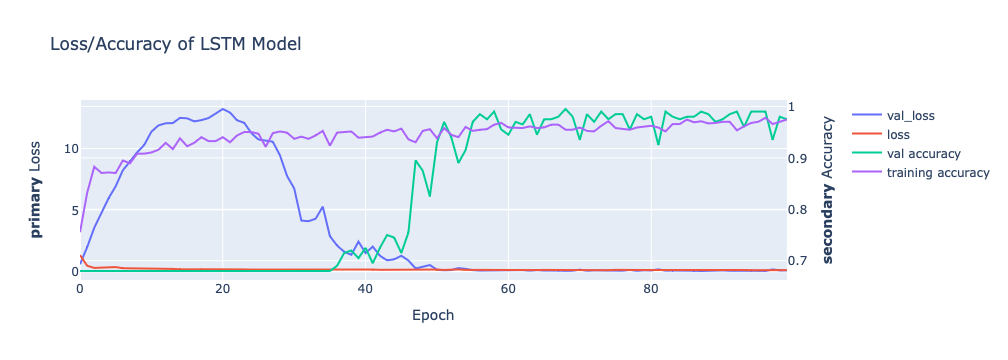

In [30]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter( y=history3.history['val_loss'], name="val_loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=history3.history['loss'], name="loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=history3.history['val_sparse_categorical_accuracy'], name="val accuracy"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter( y=history3.history['sparse_categorical_accuracy'], name="training accuracy"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Loss/Accuracy of LSTM Model"
)

# Set x-axis title
fig.update_xaxes(title_text="Epoch")

# Set y-axes titles
fig.update_yaxes(title_text="<b>primary</b> Loss", secondary_y=False)
fig.update_yaxes(title_text="<b>secondary</b> Accuracy", secondary_y=True)

fig.show()

In [31]:
model3.save('/Batch_Norm_DE3/')

INFO:tensorflow:Assets written to: /Batch_Norm_DE3/assets


INFO:tensorflow:Assets written to: /Batch_Norm_DE3/assets


In [32]:
test_set = test_datagen.flow_from_directory(os.path.join(test_directory, 'all_2d_val'), # this is where you specify the path to the main data folder
                                                 target_size=(109,91),
                                                 color_mode='rgb',
                                                 batch_size=186,
                                                 seed = 42,
                                                 class_mode='sparse',
                                                 shuffle=True)

Found 186 images belonging to 2 classes.


In [33]:
y_train, y_test = next(test_set)

In [34]:
def predict_proba(X, model, num_samples):
    preds = [model(X, training=True) for _ in range(num_samples)]
    return np.stack(preds).mean(axis=0)

def predict_class(X, model, num_samples):
    proba_preds = predict_proba(X, model, num_samples)
    return np.argmax(proba_preds, axis=1)


In [35]:
#100 different samples of prediction with dropout ON
num_samples = 100

In [36]:
pred1 = predict_class(y_train, model1, num_samples)
acc = np.mean(pred1 == y_test)
acc

0.946236559139785

In [37]:
pred2 = predict_class(y_train, model2, num_samples)
acc = np.mean(pred2 == y_test)
acc

0.8978494623655914

In [38]:
pred3 = predict_class(y_train, model3, num_samples)
acc = np.mean(pred3 == y_test)
acc

0.9623655913978495

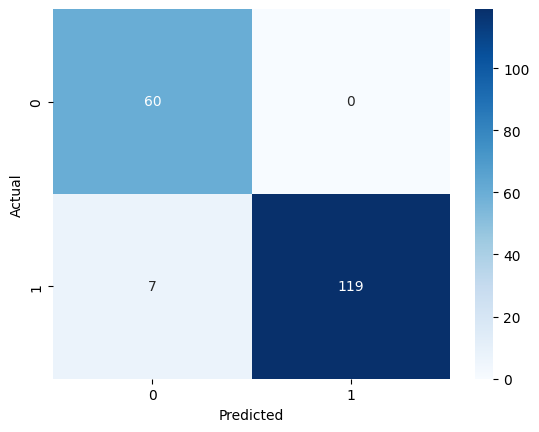

In [39]:
#import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix



# Assuming you have a 1D array called 'predicted_labels' and a 1D array called 'actual_labels'
cm = confusion_matrix(y_test, pred3)

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [40]:
prob1 = predict_proba(y_train, model1, num_samples)

In [41]:
prob2 = predict_proba(y_train, model2, num_samples)

In [42]:
prob3 = predict_proba(y_train, model3, num_samples)

In [43]:
# Average the predictions from both models
ensemble_probabilities = (prob1 + prob2 + prob3) / 3.0

# Convert the ensemble predictions to binary predictions (0 or 1) using a threshold (e.g., 0.5)
binary_ensemble_predictions = np.argmax(ensemble_probabilities, axis=1)

In [44]:
binary_ensemble_predictions

array([1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1])

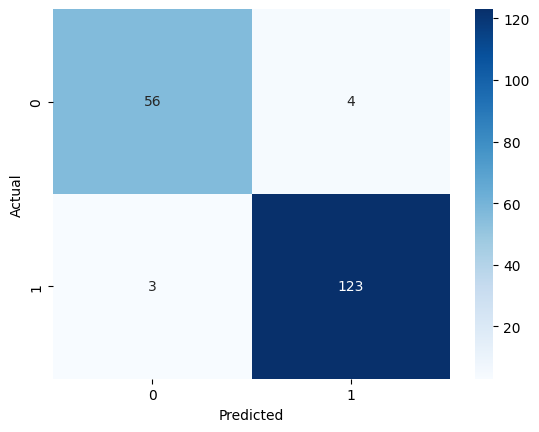

In [45]:
#DEEP ENSEMBLE CONFUSION MATRIX
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix



# Assuming you have a 1D array called 'predicted_labels' and a 1D array called 'actual_labels'
cm = confusion_matrix(y_test, binary_ensemble_predictions)

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [46]:
#DEEP ENSEMBLE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Assuming you have a 1D array called 'predicted_labels' and a 1D array called 'actual_labels'
accuracy = accuracy_score(y_test, binary_ensemble_predictions)
precision = precision_score(y_test, binary_ensemble_predictions)
recall = recall_score(y_test, binary_ensemble_predictions)
f1 = f1_score(y_test, binary_ensemble_predictions)
classification = classification_report(y_test, binary_ensemble_predictions)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)
print('Classification report:\n', classification)

Accuracy: 0.9623655913978495
Precision: 0.968503937007874
Recall: 0.9761904761904762
F1-score: 0.9723320158102767
Classification report:
               precision    recall  f1-score   support

         0.0       0.95      0.93      0.94        60
         1.0       0.97      0.98      0.97       126

    accuracy                           0.96       186
   macro avg       0.96      0.95      0.96       186
weighted avg       0.96      0.96      0.96       186



In [47]:
#3rd DE MODEL
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Assuming you have a 1D array called 'predicted_labels' and a 1D array called 'actual_labels'
accuracy = accuracy_score(y_test, pred3)
precision = precision_score(y_test, pred3)
recall = recall_score(y_test, pred3)
f1 = f1_score(y_test, pred3)
classification = classification_report(y_test, pred3)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)
print('Classification report:\n', classification)

Accuracy: 0.9623655913978495
Precision: 1.0
Recall: 0.9444444444444444
F1-score: 0.9714285714285714
Classification report:
               precision    recall  f1-score   support

         0.0       0.90      1.00      0.94        60
         1.0       1.00      0.94      0.97       126

    accuracy                           0.96       186
   macro avg       0.95      0.97      0.96       186
weighted avg       0.97      0.96      0.96       186



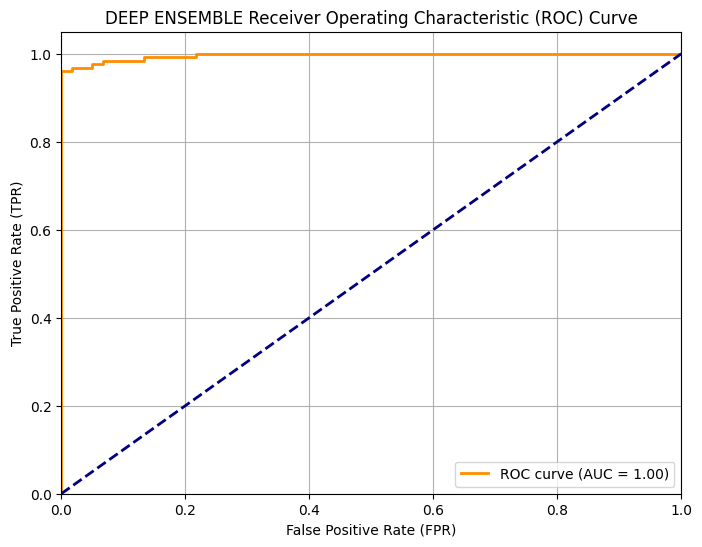

In [48]:
#DEEP ENSEMBLE ROC CURVE
from sklearn.metrics import roc_curve, auc

# Assuming y_test contains the true binary labels (ground truth)
# mc_pred_proba_array contains the predicted probabilities for both classes
# mc_pred_proba_array should be of shape (n_samples, 2) for a binary classification problem

# Calculate the False Positive Rate (FPR), True Positive Rate (TPR), and corresponding thresholds
fpr, tpr, thresholds = roc_curve(y_test, ensemble_probabilities[:, 1])  # Use probabilities for the positive class

# Calculate the Area Under the Curve (AUC) of the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('DEEP ENSEMBLE Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [49]:
#FOR TEST SET
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

n_samples = y_train.shape[0]
n_pixels = y_train.shape[1] * y_train.shape[2] * y_train.shape[3]
X = y_train.reshape(n_samples, n_pixels)

# Standardize the data
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Fit PCA model
pca = PCA(n_components=2)
pca.fit(X_std)

# Transform data to principal components
X_pca = pca.transform(X_std)

In [50]:
# calculate entropy for each row for CNN_BATCH_NORM3(3rd MODEL)
probs_array3 = np.array(prob3)
entropy3 = -probs_array3 * np.log2(probs_array3)
entropy3 = np.sum(entropy3, axis=1)

# print the first 10 entropy values
print(entropy3[:10])
entropy3.shape

[1.6884629e-04 3.9954665e-01 6.7268596e-03 9.6287150e-03 2.8059734e-03
 6.7418911e-02 1.8132777e-03 1.0978562e-02 4.0669227e-05 7.7960631e-03]


(186,)

In [51]:
# calculate entropy for each row for DEEP ENSEMBLE
probs_array = np.array(ensemble_probabilities)
entropy = -probs_array * np.log2(probs_array)
entropy = np.sum(entropy, axis=1)

# print the first 10 entropy values
print(entropy[:10])
entropy.shape

[0.09168992 0.30533215 0.07245323 0.14431512 0.17474496 0.6506346
 0.0525405  0.55923474 0.14269392 0.03894159]


(186,)

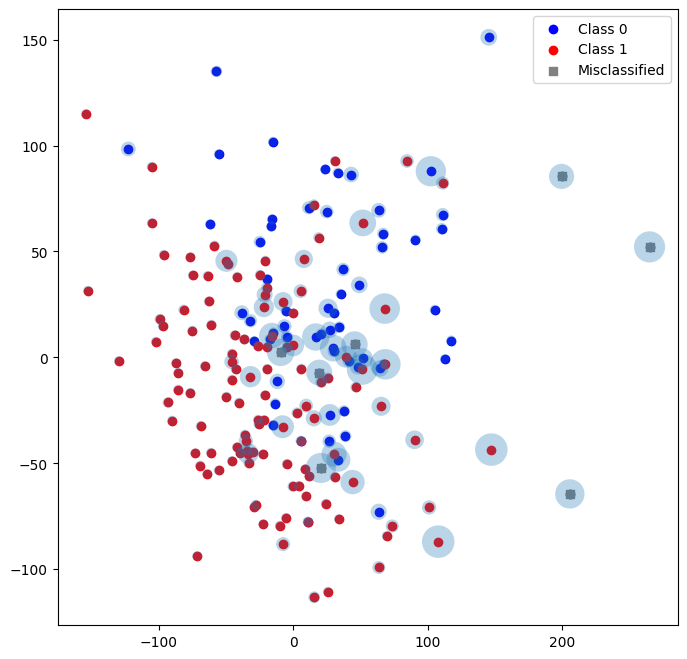

In [52]:
#@title Uncertainty Plot FOR CNN_BATCH_NORM3(3rd MODEL). {display-mode:'form', run: "auto"}
#@markdown Entropy, Predicted and True Value Plot

#@markdown Higher Entropy means higher uncertainty(INDICATED BY LARGER LIGHT BLUE MARKER AROUND THE POINTS)

transparency = 0.3 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
# from sklearn.decomposition import PCA
# Create x and y arrays from the PCA-transformed data
x = X_pca[:, 0]
y = X_pca[:, 1]

# Create arrays for uncertainty, predicted class, and true class
#uncertainty = ...  # shape (n_samples,)
#y_pred = ...  # shape (n_samples,)
colors = ['blue', 'red']  # Color for each class

# Create scatter plot
fig, ax = plt.subplots(figsize=(8, 8))
for c in range(2):
    mask = pred3 == c
    ax.scatter(x[mask], y[mask], c=colors[c], marker='o', label=f'Class {c}')
ax.scatter(x[y_test != pred3], y[y_test != pred3], c='gray', marker='s', label='Misclassified')
ax.legend()

# Add uncertainty as size of markers
sizes = 50 + 500 * entropy3
ax.scatter(x, y, s=sizes, alpha=transparency, edgecolors='none')

plt.show()

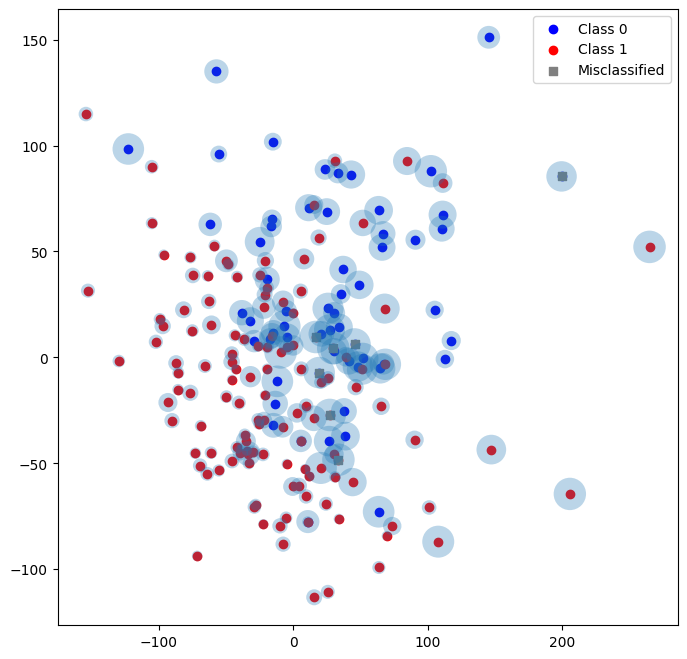

In [53]:
#@title Uncertainty Plot FOR DEEP ENSEMBLE. {display-mode:'form', run: "auto"}
#@markdown Entropy, Predicted and True Value Plot

#@markdown Higher Entropy means higher uncertainty(INDICATED BY LARGER LIGHT BLUE MARKER AROUND THE POINTS)

transparency = 0.3 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
# from sklearn.decomposition import PCA
# Create x and y arrays from the PCA-transformed data
x = X_pca[:, 0]
y = X_pca[:, 1]

# Create arrays for uncertainty, predicted class, and true class
#uncertainty = ...  # shape (n_samples,)
#y_pred = ...  # shape (n_samples,)
colors = ['blue', 'red']  # Color for each class

# Create scatter plot
fig, ax = plt.subplots(figsize=(8, 8))
for c in range(2):
    mask = binary_ensemble_predictions == c
    ax.scatter(x[mask], y[mask], c=colors[c], marker='o', label=f'Class {c}')
ax.scatter(x[y_test != binary_ensemble_predictions], y[y_test != binary_ensemble_predictions], c='gray', marker='s', label='Misclassified')
ax.legend()

# Add uncertainty as size of markers
sizes = 50 + 500 * entropy
ax.scatter(x, y, s=sizes, alpha=transparency, edgecolors='none')

plt.show()

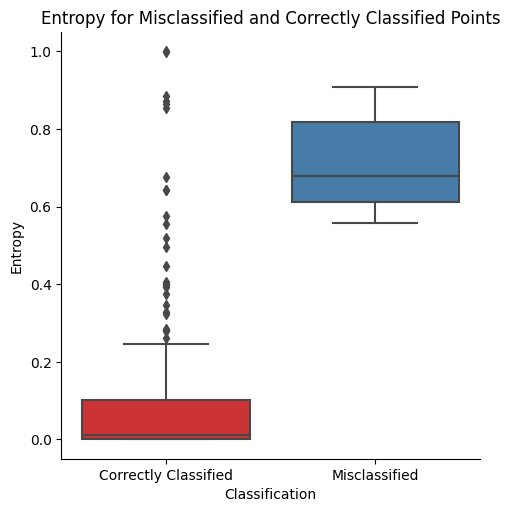

In [54]:
#3rd MODEL CATPLOT
# Compare the predictions with the true values to find correctly classified and misclassified points
correctly_classified = pred3 == y_test
misclassified = pred3 != y_test

# Create a pandas DataFrame to organize the data for the plot
data3_noclass = pd.DataFrame({
    'Classification': ['Correctly Classified' if x else 'Misclassified' for x in correctly_classified],
    'Entropy': entropy3
})

# Create the catplot using seaborn
sns.catplot(x='Classification', y='Entropy', data=data3_noclass, kind='box', palette='Set1')

# Set plot labels and title
plt.xlabel('Classification')
plt.ylabel('Entropy')
plt.title('Entropy for Misclassified and Correctly Classified Points')

# Show the plot
plt.show()

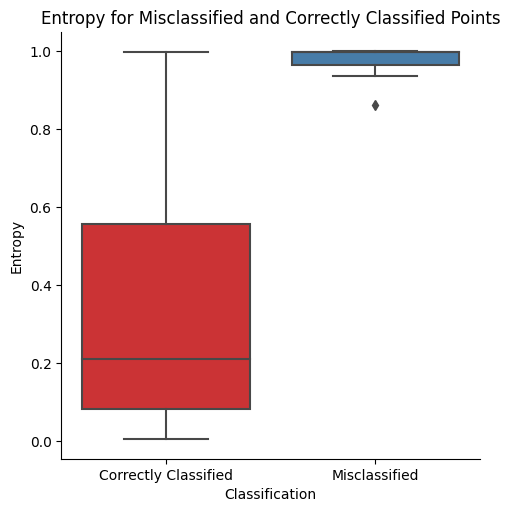

In [55]:
#DEEP ENSEMBLE CATPLOT
# Compare the predictions with the true values to find correctly classified and misclassified points
correctly_classified = binary_ensemble_predictions == y_test
misclassified = binary_ensemble_predictions != y_test

# Create a pandas DataFrame to organize the data for the plot
data_noclass = pd.DataFrame({
    'Classification': ['Correctly Classified' if x else 'Misclassified' for x in correctly_classified],
    'Entropy': entropy
})

# Create the catplot using seaborn
sns.catplot(x='Classification', y='Entropy', data=data_noclass, kind='box', palette='Set1')

# Set plot labels and title
plt.xlabel('Classification')
plt.ylabel('Entropy')
plt.title('Entropy for Misclassified and Correctly Classified Points')

# Show the plot
plt.show()

In [56]:
y_test_string = np.where(y_test, "PD", "HC")
data_pd = data_noclass.copy()
data_pd['Class'] = y_test_string

In [57]:
data3_pd = data3_noclass.copy()
data3_pd['Class'] = y_test_string

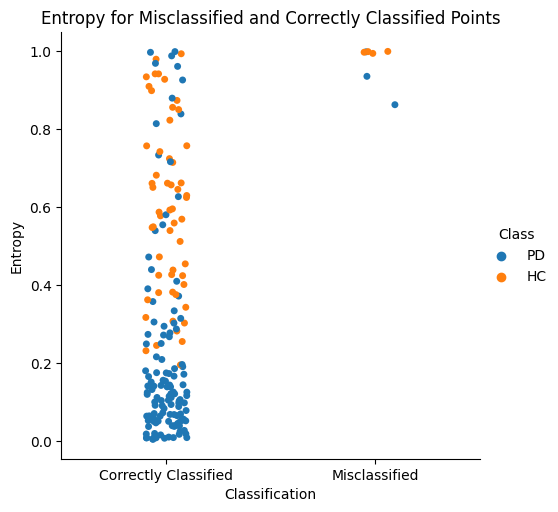

In [58]:
#Deep Ensemble
# Create the catplot using seaborn
sns.catplot(x='Classification', y='Entropy', data=data_pd, hue = 'Class')

# Set plot labels and title
plt.xlabel('Classification')
plt.ylabel('Entropy')
plt.title('Entropy for Misclassified and Correctly Classified Points')

# Show the plot
plt.show()

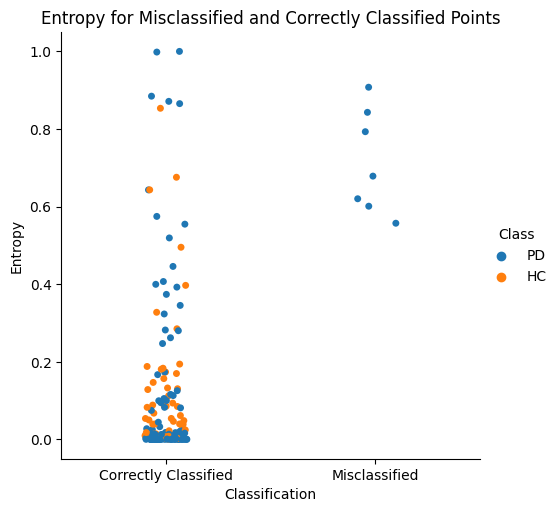

In [59]:
#3rd Model
# Create the catplot using seaborn
sns.catplot(x='Classification', y='Entropy', data=data3_pd, hue = 'Class')

# Set plot labels and title
plt.xlabel('Classification')
plt.ylabel('Entropy')
plt.title('Entropy for Misclassified and Correctly Classified Points')

# Show the plot
plt.show()

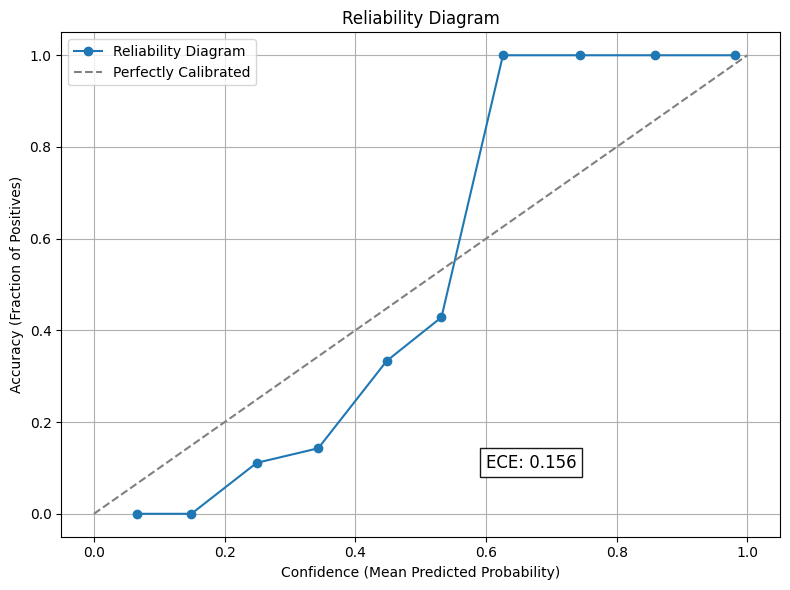

In [60]:
#DEEP ENSEMBLE RELIABILITY PLOT
from sklearn.calibration import calibration_curve
num_bins = 10

# Calculate reliability diagram data
prob_true, prob_pred = calibration_curve(y_test, ensemble_probabilities[:, 1], n_bins=num_bins, strategy='uniform')

# Calculate the ECE
ece_confidence = np.mean(np.abs(prob_pred - prob_true))

# Plot the reliability diagram and ECE
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label='Reliability Diagram')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Confidence (Mean Predicted Probability)')
plt.ylabel('Accuracy (Fraction of Positives)')
plt.title('Reliability Diagram')
plt.legend()

# Display the ECE value in the plot
plt.text(0.6, 0.1, f'ECE: {ece_confidence:.3f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.9))

plt.grid(True)
plt.tight_layout()
plt.show()

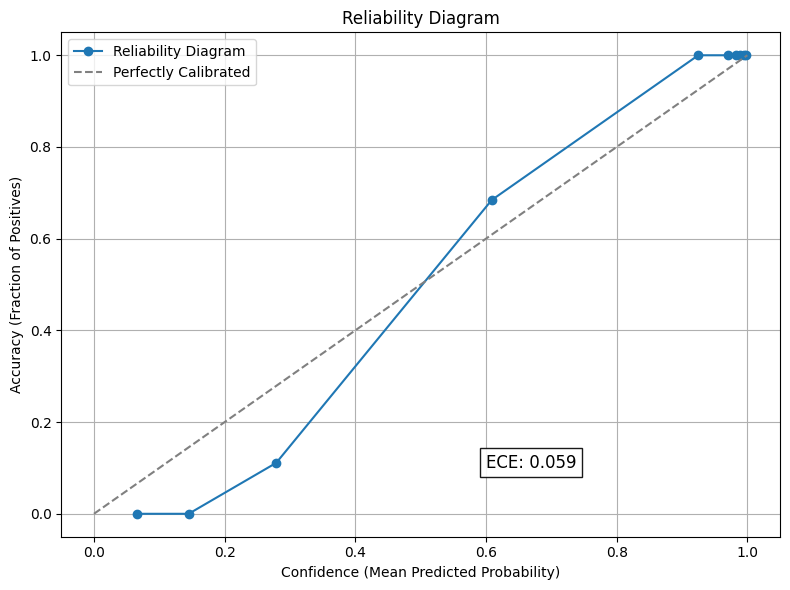

In [61]:
#DEEP ENSEMBLE RELIABILITY PLOT
from sklearn.calibration import calibration_curve
num_bins = 10

# Calculate reliability diagram data
prob_true, prob_pred = calibration_curve(y_test, ensemble_probabilities[:, 1], n_bins=num_bins, strategy='quantile')

# Calculate the ECE
ece_confidence = np.mean(np.abs(prob_pred - prob_true))

# Plot the reliability diagram and ECE
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label='Reliability Diagram')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Confidence (Mean Predicted Probability)')
plt.ylabel('Accuracy (Fraction of Positives)')
plt.title('Reliability Diagram')
plt.legend()

# Display the ECE value in the plot
plt.text(0.6, 0.1, f'ECE: {ece_confidence:.3f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.9))

plt.grid(True)
plt.tight_layout()
plt.show()

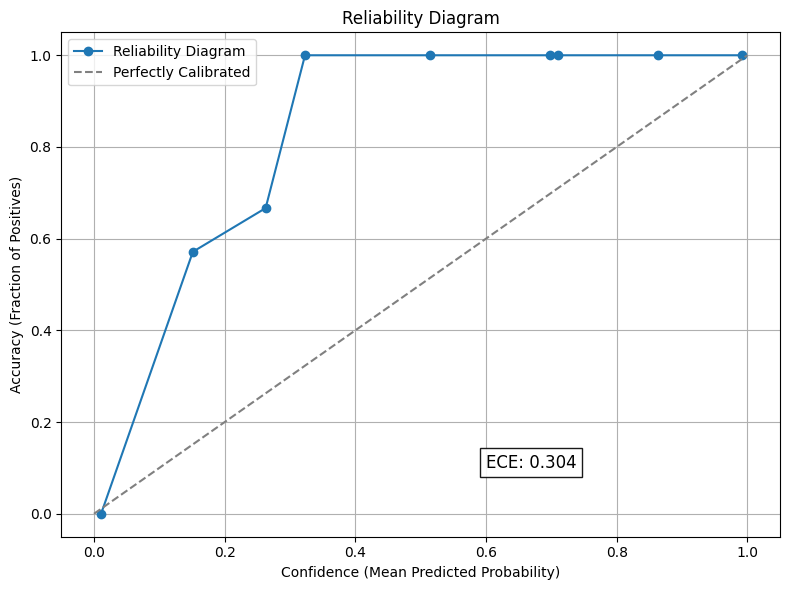

In [62]:
#3rd MODEL RELIABILITY DIAGRAM
num_bins = 10

# Calculate reliability diagram data
prob_true3, prob_pred3 = calibration_curve(y_test, prob3[:, 1], n_bins=num_bins, strategy='uniform')

# Calculate the ECE
ece_confidence3 = np.mean(np.abs(prob_pred3 - prob_true3))

# Plot the reliability diagram and ECE
plt.figure(figsize=(8, 6))
plt.plot(prob_pred3, prob_true3, marker='o', linestyle='-', label='Reliability Diagram')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Confidence (Mean Predicted Probability)')
plt.ylabel('Accuracy (Fraction of Positives)')
plt.title('Reliability Diagram')
plt.legend()

# Display the ECE value in the plot
plt.text(0.6, 0.1, f'ECE: {ece_confidence3:.3f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.9))

plt.grid(True)
plt.tight_layout()
plt.show()

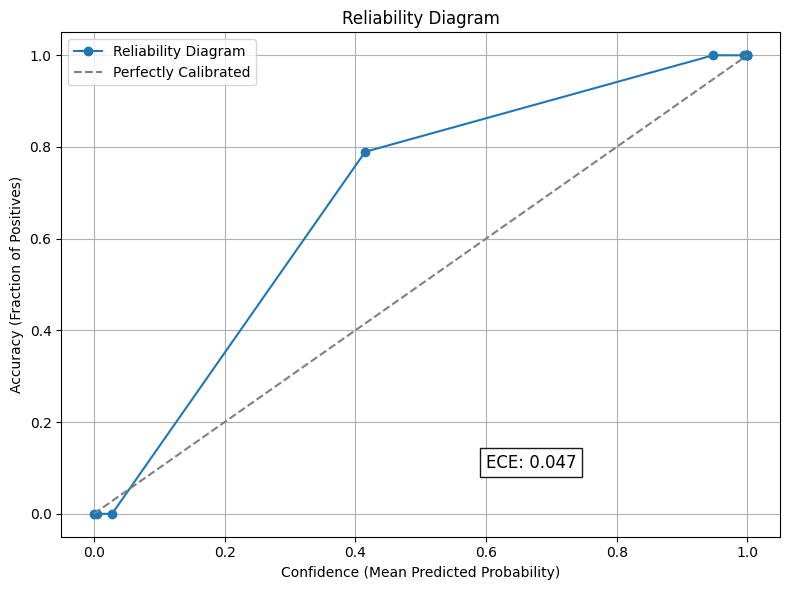

In [63]:
#3rd MODEL RELIABILITY DIAGRAM
num_bins = 10

# Calculate reliability diagram data
prob_true3, prob_pred3 = calibration_curve(y_test, prob3[:, 1], n_bins=num_bins, strategy='quantile')

# Calculate the ECE
ece_confidence3 = np.mean(np.abs(prob_pred3 - prob_true3))

# Plot the reliability diagram and ECE
plt.figure(figsize=(8, 6))
plt.plot(prob_pred3, prob_true3, marker='o', linestyle='-', label='Reliability Diagram')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Confidence (Mean Predicted Probability)')
plt.ylabel('Accuracy (Fraction of Positives)')
plt.title('Reliability Diagram')
plt.legend()

# Display the ECE value in the plot
plt.text(0.6, 0.1, f'ECE: {ece_confidence3:.3f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.9))

plt.grid(True)
plt.tight_layout()
plt.show()

In [64]:
def logits_from_probabilities(probabilities):
    return np.log(probabilities / (1 - probabilities))

# Convert probabilities to logits
logits_ensemble = logits_from_probabilities(ensemble_probabilities)

In [65]:
logits_ensemble_1 = logits_ensemble[:, 1]
logits_ensemble_1.shape

(186,)

In [66]:
# Temperature Scaling
temp = tf.Variable(initial_value=1.0, trainable=True, dtype=tf.float32)

def compute_loss():
    y_pred_model_w_temp = tf.math.divide(logits_ensemble_1, temp)
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.convert_to_tensor(y_test), logits=y_pred_model_w_temp))
    return loss

optimizer = tf.optimizers.Adam(learning_rate=0.01)

print('Temperature Initial value: {}'.format(temp.numpy()))
for i in range(300):
    opts = optimizer.minimize(compute_loss, var_list=[temp])

print('Temperature Final value: {}'.format(temp.numpy()))

Temperature Initial value: 1.0
Temperature Final value: 0.322759211063385


In [67]:
#New Logits by rescaling method
y_pred_temp_logits_final = tf.math.divide(logits_ensemble_1, temp)

In [68]:
def sigmoid(logits):
    return 1 / (1 + np.exp(-logits))

In [69]:
temp_scaled_probabilities = sigmoid(y_pred_temp_logits_final)
temp_scaled_probabilities.shape

(186,)

In [70]:
temp_scaled_probabilities_0 = 1 - temp_scaled_probabilities

# Create the 2D array with probabilities of class 0 and class 1
probability_matrix_scaled = np.column_stack((temp_scaled_probabilities_0, temp_scaled_probabilities))
probability_matrix_scaled.shape

(186, 2)

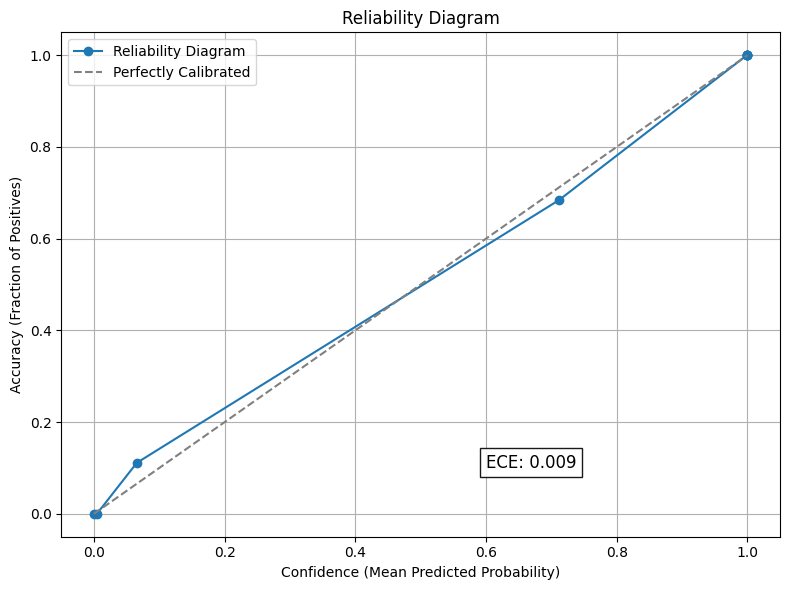

In [71]:
#SCALING THROUGH TensorFLOW TensorFloW scaling method
num_bins = 10

# Calculate reliability diagram data
prob_true, prob_pred = calibration_curve(y_test, probability_matrix_scaled[:, 1], n_bins=num_bins, strategy='quantile')

# Calculate the ECE
ece_confidence_scaled = np.mean(np.abs(prob_pred - prob_true))

# Plot the reliability diagram and ECE
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label='Reliability Diagram')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Confidence (Mean Predicted Probability)')
plt.ylabel('Accuracy (Fraction of Positives)')
plt.title('Reliability Diagram')
plt.legend()

# Display the ECE value in the plot
plt.text(0.6, 0.1, f'ECE: {ece_confidence_scaled:.3f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.9))

plt.grid(True)
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

/opt/conda/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

/opt/conda/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to th

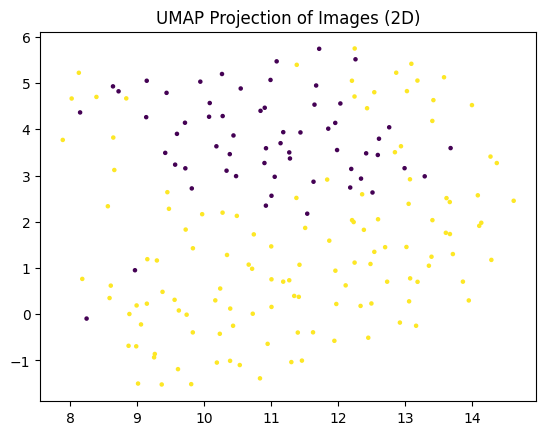

In [72]:
import umap.umap_ as umap 

# Create a UMAP model
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.6, n_components=2, random_state = 42)

# Fit and transform the data
umap_result = umap_model.fit_transform(X_std)

# Visualize the 2D points
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=y_test, cmap='viridis', s=5)
plt.title("UMAP Projection of Images (2D)")
plt.show()

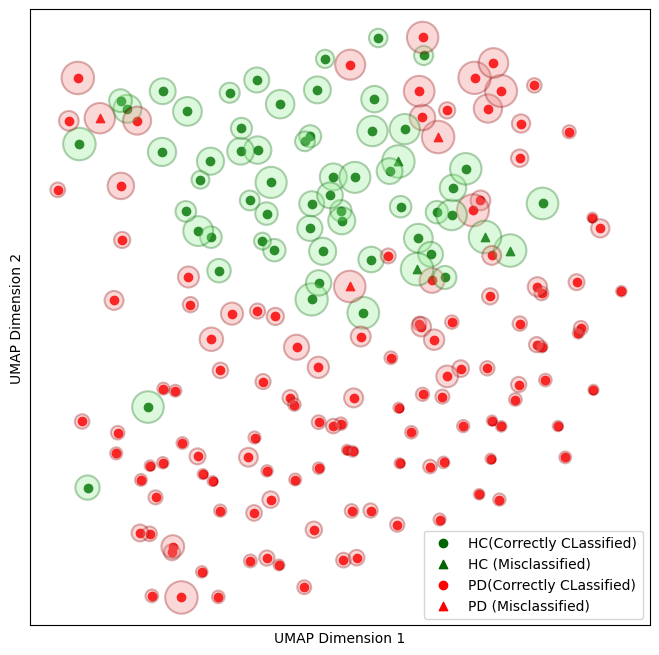

In [73]:
#BEST!!Deep Ensemble
# Create x and y arrays from the t-SNE results
x = umap_result[:, 0]
y = umap_result[:, 1]

fig, ax = plt.subplots(figsize=(8, 8))

for c in range(2):
    mask = y_test == c  # Use ground truth labels for class mask
    
    # Correctly classified points as circles
    if c == 1:
        correct_mask = (y_test == binary_ensemble_predictions) & (y_test == 1)
        ax.scatter(x[correct_mask], y[correct_mask], marker='o', color='red', label='PD(Correctly CLassified)')
    else:
        correct_mask = (y_test == binary_ensemble_predictions) & (y_test == 0)
        ax.scatter(x[correct_mask], y[correct_mask], marker='o', color='darkgreen', label='HC(Correctly CLassified)')
    
    # Misclassified points as triangles
    misclassified_mask = (y_test != binary_ensemble_predictions) & (y_test == c)
    if c == 1:
        ax.scatter(x[misclassified_mask], y[misclassified_mask], marker='^', color='red', label='PD (Misclassified)')
    else:
        ax.scatter(x[misclassified_mask], y[misclassified_mask], marker='^', color='darkgreen', label='HC (Misclassified)')

# Add legend
ax.legend()

# Add uncertainty as size of markers
sizes = 50 + 500 * entropy  # Modify the sizes based on uncertainty
uncertainty_colors = np.where(y_test == 1,'lightcoral', 'lightgreen')
edge_colors = np.where(y_test == 1, 'darkred', 'darkgreen')  # Use 'darkgreen' and 'darkred' for edge colors

ax.scatter(x, y, s=sizes, c=uncertainty_colors, alpha=transparency, edgecolor = edge_colors,  linewidths=1.5)
ax.set_xlabel('UMAP Dimension 1')
ax.set_ylabel('UMAP Dimension 2')

#Remove axes
ax.set_xticks([])
ax.set_yticks([])

plt.show()

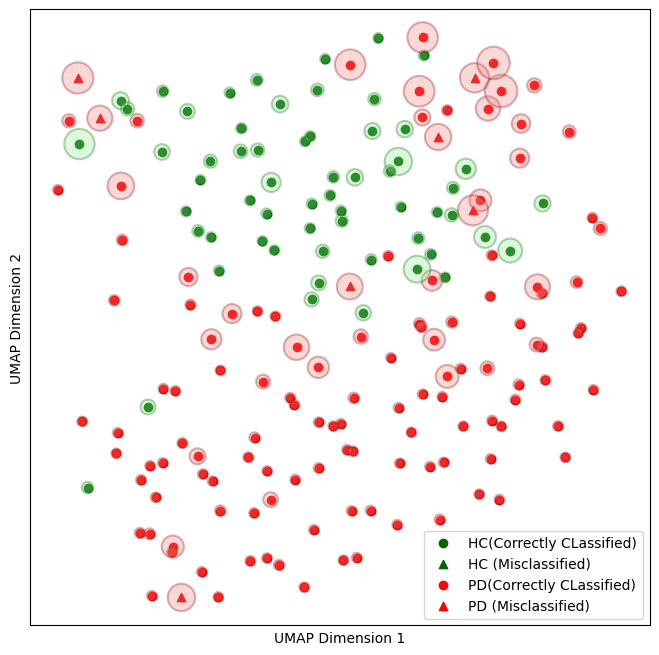

In [74]:
#BEST!!3rd Model
# Create x and y arrays from the t-SNE results
x = umap_result[:, 0]
y = umap_result[:, 1]

fig, ax = plt.subplots(figsize=(8, 8))

for c in range(2):
    mask = y_test == c  # Use ground truth labels for class mask
    
    # Correctly classified points as circles
    if c == 1:
        correct_mask = (y_test == pred3) & (y_test == 1)
        ax.scatter(x[correct_mask], y[correct_mask], marker='o', color='red', label='PD(Correctly CLassified)')
    else:
        correct_mask = (y_test == pred3) & (y_test == 0)
        ax.scatter(x[correct_mask], y[correct_mask], marker='o', color='darkgreen', label='HC(Correctly CLassified)')
    
    # Misclassified points as triangles
    misclassified_mask = (y_test != pred3) & (y_test == c)
    if c == 1:
        ax.scatter(x[misclassified_mask], y[misclassified_mask], marker='^', color='red', label='PD (Misclassified)')
    else:
        ax.scatter(x[misclassified_mask], y[misclassified_mask], marker='^', color='darkgreen', label='HC (Misclassified)')

# Add legend
ax.legend()

# Add uncertainty as size of markers
sizes = 50 + 500 * entropy3  # Modify the sizes based on uncertainty
uncertainty_colors = np.where(y_test == 1,'lightcoral', 'lightgreen') 
edge_colors = np.where(y_test == 1, 'darkred', 'darkgreen')  # Use 'darkgreen' and 'darkred' for edge colors
ax.set_xlabel('UMAP Dimension 1')
ax.set_ylabel('UMAP Dimension 2')


ax.scatter(x, y, s=sizes, c=uncertainty_colors, alpha=transparency, edgecolor = edge_colors,  linewidths=1.5)
#Remove axes
ax.set_xticks([])
ax.set_yticks([])

plt.show()

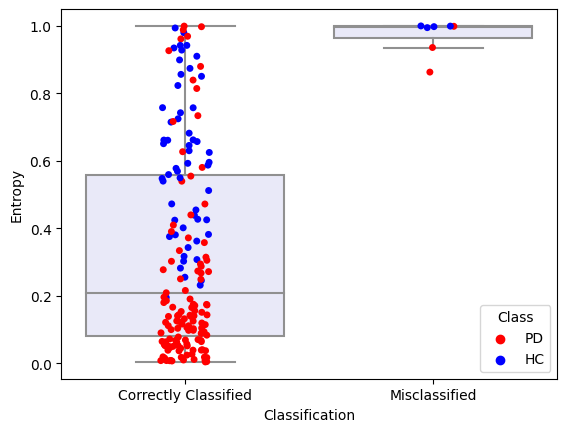

In [75]:
#DEEP ENSEMBLE
box_color_palette = ['#E6E6FA','#E6E6FA']# colors=[lavender, lavender]
strip_color_palette = {'HC': '#0000FF', 'PD': '#FF0000'}# colors=[bright red, bright blue]
fig, ax = plt.subplots()
ax = sns.boxplot(x='Classification', y='Entropy', data=data_noclass, palette=box_color_palette, showfliers=False)

sns.stripplot(x='Classification', y='Entropy', data=data_pd, hue = 'Class', ax=ax, palette=strip_color_palette)
plt.show()

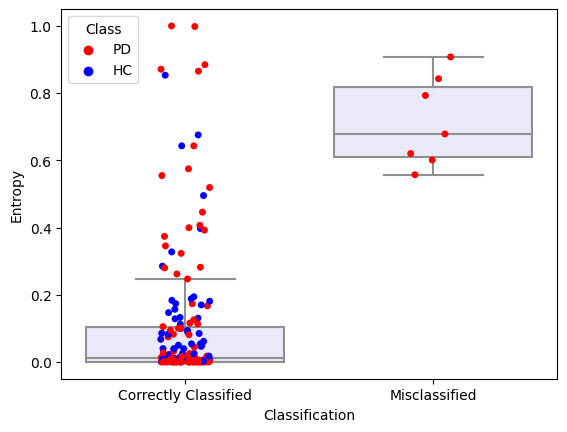

In [76]:
#3RD MODEL
box_color_palette = ['#E6E6FA','#E6E6FA']# colors=[lavender, lavender]
strip_color_palette = {'HC': '#0000FF', 'PD': '#FF0000'}# colors=[bright red, bright blue]
fig, ax = plt.subplots()
ax = sns.boxplot(x='Classification', y='Entropy', data=data3_noclass, palette=box_color_palette, showfliers=False)

sns.stripplot(x='Classification', y='Entropy', data=data3_pd, hue = 'Class', ax=ax, palette=strip_color_palette)
plt.show()

In [77]:
# Step 1: Find Misclassified Point with Lowest Entropy(DEEP ENSEMBLE)
misclassified_points = data_pd[data_pd['Classification'] == 'Misclassified']
misclassified_points_sorted = misclassified_points.sort_values(by='Entropy', ascending=True)
lowest_entropy_misclassified = misclassified_points_sorted.iloc[0]

# Step 2: Use Lowest Entropy as Threshold
entropy_threshold = lowest_entropy_misclassified['Entropy']

# Step 3: Count Points Above Threshold
points_above_threshold = data_pd[data_pd['Entropy'] > entropy_threshold]

# Count Correctly Classified and Misclassified points above the threshold
correctly_classified_above_threshold = len(points_above_threshold[points_above_threshold['Classification'] == 'Correctly Classified'])
misclassified_above_threshold = len(points_above_threshold[points_above_threshold['Classification'] == 'Misclassified'])
total_above_threshold = correctly_classified_above_threshold + misclassified_above_threshold

# Display results
print(f"Lowest entropy misclassified point: {lowest_entropy_misclassified}")
print(f"Entropy threshold: {entropy_threshold}")
print(f"Number of Correctly Classified points above threshold: {correctly_classified_above_threshold}")
print(f"Number of Misclassified points above threshold: {misclassified_above_threshold}")
print(f"Total Number of samples above threshold: {total_above_threshold}")

Lowest entropy misclassified point: Classification    Misclassified
Entropy                0.862733
Class                        PD
Name: 13, dtype: object
Entropy threshold: 0.8627330660820007
Number of Correctly Classified points above threshold: 16
Number of Misclassified points above threshold: 6
Total Number of samples above threshold: 22


In [78]:
# Step 1: Find Misclassified Point with Lowest Entropy(3RD DE)
misclassified_points = data3_pd[data_pd['Classification'] == 'Misclassified']
misclassified_points_sorted = misclassified_points.sort_values(by='Entropy', ascending=True)
lowest_entropy_misclassified = misclassified_points_sorted.iloc[0]

# Step 2: Use Lowest Entropy as Threshold
entropy_threshold = lowest_entropy_misclassified['Entropy']

# Step 3: Count Points Above Threshold
points_above_threshold = data3_pd[data3_pd['Entropy'] > entropy_threshold]

# Count Correctly Classified and Misclassified points above the threshold
correctly_classified_above_threshold = len(points_above_threshold[points_above_threshold['Classification'] == 'Correctly Classified'])
misclassified_above_threshold = len(points_above_threshold[points_above_threshold['Classification'] == 'Misclassified'])
total_above_threshold = correctly_classified_above_threshold + misclassified_above_threshold

# Display results
print(f"Lowest entropy misclassified point: {lowest_entropy_misclassified}")
print(f"Entropy threshold: {entropy_threshold}")
print(f"Number of Correctly Classified points above threshold: {correctly_classified_above_threshold}")
print(f"Number of Misclassified points above threshold: {misclassified_above_threshold}")
print(f"Total Number of samples above threshold: {total_above_threshold}")

Lowest entropy misclassified point: Classification    Correctly Classified
Entropy                       0.396878
Class                               HC
Name: 78, dtype: object
Entropy threshold: 0.39687803387641907
Number of Correctly Classified points above threshold: 16
Number of Misclassified points above threshold: 7
Total Number of samples above threshold: 23


In [79]:
# Step 1: Preprocess Data 1 = Correctly Classified, 0 = misclassified(DE)
data_pd['Label'] = (data_pd['Classification'] == 'Correctly Classified').astype(int)
data_pd["Entropy"] = data_pd["Entropy"].fillna(0)
classification_array = data_pd['Label'].values
entropy_array  = data_pd['Entropy'].values

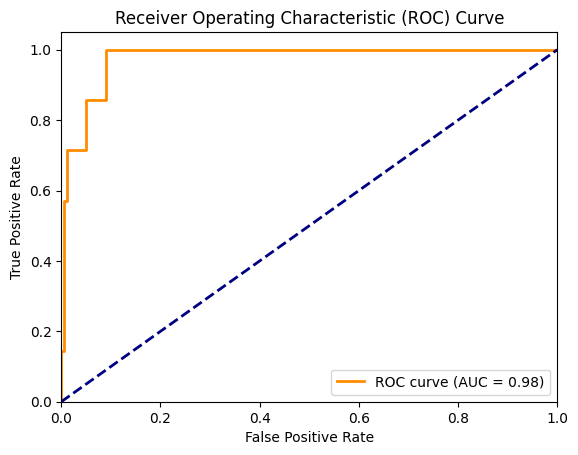

In [80]:
# Calculate true positive rate (sensitivity) and false positive rate for different thresholds(DE)
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(classification_array, entropy_array)
from sklearn.metrics import auc as sklearn_auc

# Calculate AUC
roc_auc = sklearn_auc(tpr, fpr)

# Plotting ROC curve
plt.figure()
plt.plot(tpr, fpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [81]:
# Step 1: Preprocess Data 1 = Correctly Classified, 0 = misclassified(3rD)
data3_pd['Label'] = (data3_pd['Classification'] == 'Correctly Classified').astype(int)
data_pd["Entropy"] = data_pd["Entropy"].fillna(0)
classification3_array = data3_pd['Label'].values
entropy3_array  = data3_pd['Entropy'].values

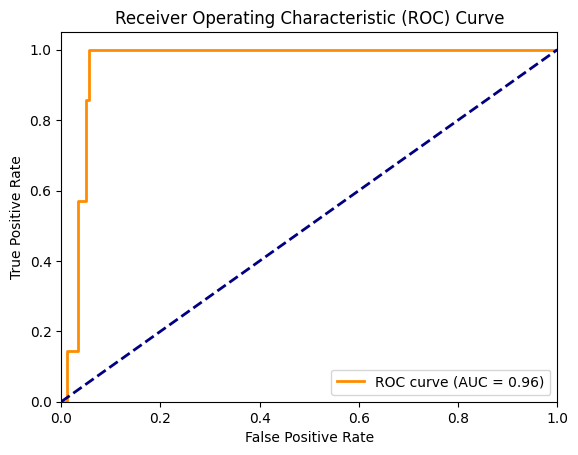

In [82]:
# Calculate true positive rate (sensitivity) and false positive rate for different thresholds(3rD)
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(classification3_array, entropy3_array)
from sklearn.metrics import auc as sklearn_auc

# Calculate AUC
roc_auc = sklearn_auc(tpr, fpr)

# Plotting ROC curve
plt.figure()
plt.plot(tpr, fpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [83]:
data_pd

Classification   Entropy Class  Label
0    Correctly Classified  0.091690    PD      1
1    Correctly Classified  0.305332    PD      1
2    Correctly Classified  0.072453    PD      1
3    Correctly Classified  0.144315    PD      1
4    Correctly Classified  0.174745    PD      1
..                    ...       ...   ...    ...
181  Correctly Classified  0.064567    PD      1
182  Correctly Classified  0.660979    HC      1
183  Correctly Classified  0.151367    PD      1
184  Correctly Classified  0.051805    PD      1
185  Correctly Classified  0.040606    PD      1

[186 rows x 4 columns]

In [84]:
data3_pd

Classification       Entropy Class  Label
0    Correctly Classified  1.688463e-04    PD      1
1    Correctly Classified  3.995467e-01    PD      1
2    Correctly Classified  6.726860e-03    PD      1
3    Correctly Classified  9.628715e-03    PD      1
4    Correctly Classified  2.805973e-03    PD      1
..                    ...           ...   ...    ...
181  Correctly Classified  1.748516e-04    PD      1
182  Correctly Classified  5.372421e-02    HC      1
183  Correctly Classified  1.094745e-04    PD      1
184  Correctly Classified  9.121275e-03    PD      1
185  Correctly Classified  2.090621e-07    PD      1

[186 rows x 4 columns]

In [85]:
data_pd.to_csv('Model_entropy_data_csv/DE_model.csv')

In [86]:
data3_pd.to_csv('Model_entropy_data_csv/3rdDE_model.csv')

In [87]:
# # Step 1: Preprocess Data 1 = Correctly Classified, 0 = misclassified
# data3_pd['Label'] = (data3_pd['Classification'] == 'Correctly Classified').astype(int)
# data3_pd = data3_pd.sort_values(by='Entropy', ascending=True)

# # Step 2: Calculate True Positive Rate and False Positive Rate
# tpr = data3_pd['Label'].cumsum() / data3_pd['Label'].sum()  # True Positive Rate (Sensitivity)
# fpr = (data3_pd['Label'] == 0).cumsum() / (data3_pd['Label'] == 0).sum()  # False Positive Rate (1-Specificity)

# from sklearn.metrics import auc as sklearn_auc

# roc_auc = sklearn_auc(fpr, tpr)

# # Step 3: Plot the Curve
# plt.figure(figsize=(6, 6))
# plt.plot(fpr, tpr, marker='o', color='b', label=f'ROC-like Curve (AUC = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC-like Curve')
# plt.legend()
# plt.grid(True)
# plt.show()

In [88]:
# # Step 1: Preprocess Data 1 = Correctly Classified, 0 = misclassified
# data_pd['Label'] = (data_pd['Classification'] == 'Correctly Classified').astype(int)
# data_pd = data_pd.sort_values(by='Entropy', ascending=True)

# # Step 2: Calculate True Positive Rate and False Positive Rate
# tpr = data_pd['Label'].cumsum() / data_pd['Label'].sum()  # True Positive Rate (Sensitivity)
# fpr = (data_pd['Label'] == 0).cumsum() / (data_pd['Label'] == 0).sum()  # False Positive Rate (1-Specificity)
# from sklearn.metrics import auc as sklearn_auc

# roc_auc = sklearn_auc(fpr, tpr)

# # Step 3: Plot the Curve
# plt.figure(figsize=(6, 6))
# plt.plot(fpr, tpr, marker='o', color='b', label=f'ROC-like Curve (AUC = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC-like Curve')
# plt.legend()
# plt.grid(True)
# plt.show()

In [89]:
# # Step 1: Preprocess Data 1 = Correctly Classified, 0 = misclassified
# #data_pd['Label'] = (data_pd['Classification'] == 'Correctly Classified').astype(int)
# data_pd = data_pd.sort_values(by='Entropy', ascending=True)

# # Step 2: Calculate True Positive Rate and False Positive Rate
# tpr = data_pd['Label'].cumsum() / data_pd['Label'].sum()  # True Positive Rate (Sensitivity)
# fpr = (data_pd['Label'] == 0).cumsum() / (data_pd['Label'] == 0).sum()  # False Positive Rate (1-Specificity)

# # Step 3: Plot the Curve
# plt.figure(figsize=(6, 6))
# plt.plot(fpr, tpr, marker='o', color='b', label='ROC-like Curve')
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC-like Curve')
# plt.legend()
# plt.grid(True)
# plt.show()